In [ ]:
# Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import re # Para expressões regulares na função de parse
from datetime import datetime # Para a função de parse

# Suprimir avisos de overflow/runtime que podem ocorrer em cálculos numéricos intensos
# warnings.filterwarnings('ignore', category=RuntimeWarning)
# warnings.filterwarnings('ignore', category=OverflowError) # OverflowError não é um Warning

In [ ]:
# ==============================================================================
# 1. Modelo do Painel PV e Cálculo do MPP Real
# ==============================================================================

# Parâmetros do painel fotovoltaico (modelo de diodo único)
Iscn = 8.21  # Corrente de curto-circuito nominal (A)
Vocn = 32.9  # Tensão de circuito aberto nominal (V)
Kv = -0.123  # Coeficiente de temperatura para tensão (V/°C)
Ki = 0.0032  # Coeficiente de temperatura para corrente (A/°C)
Ns = 54      # Número de células em série
Gn = 1000    # Irradiância nominal (W/m^2)
Tn = 25      # Temperatura nominal (°C)
k = 1.38e-23 # Constante de Boltzmann
q = 1.6e-19  # Carga do elétron
A = 1.5      # Fator de idealidade do diodo
Rs = 0.3     # Resistência série (Ω)
Rsh = 1000   # Resistência shunt (Ω)

# Função para calcular a corrente do painel (COM ALTERAÇÃO NA VERIFICAÇÃO FINAL)
def calcular_corrente_pv(V, G, T_c):
    # Garante que G e T_c sejam arrays numpy para operações vetoriais consistentes
    G = np.asarray(G)
    T_c = np.asarray(T_c)
    V = np.asarray(V)

    # Retorna 0 onde G <= 0
    resultado = np.zeros_like(V, dtype=float)
    mask_valid_g = G > 0

    if not np.any(mask_valid_g):
        return resultado

    # Filtra os valores para processar apenas onde G > 0
    V_proc = V[mask_valid_g]
    G_proc = G[mask_valid_g]
    T_c_proc = T_c[mask_valid_g]

    T_c_k = T_c_proc + 273.15
    T_n_k = Tn + 273.15
    Iph = (Iscn + Ki * (T_c_k - T_n_k)) * (G_proc / Gn)

    # Cálculo de I0 com tratamento para evitar overflow/underflow potencial
    try:
        arg_exp_I0 = Vocn * q / (A * k * T_n_k * Ns)
        arg_exp_I0 = np.clip(arg_exp_I0, -700, 700)
        exp_term_I0 = np.exp(arg_exp_I0)

        arg_exp_T_dep = q * 1.1 / (A * k) * (1/T_n_k - 1/T_c_k)
        arg_exp_T_dep = np.clip(arg_exp_T_dep, -700, 700)
        exp_term_T_dep = np.exp(arg_exp_T_dep)

        denominator_I0 = exp_term_I0 - 1

        mask = np.abs(denominator_I0) < 1e-12
        signs = np.sign(denominator_I0)
        signs = np.where(signs == 0, 1.0, signs)  # Evita multiplicação por zero
        denominator_I0 = np.where(mask, signs * 1e-12, denominator_I0)

        I0 = (Iscn / denominator_I0) * exp_term_T_dep
        I0 = np.nan_to_num(I0, nan=1e-9, posinf=1e-3, neginf=-1e-3)
        I0 = np.clip(I0, 1e-12, 1e-3)

    except OverflowError:
        I0 = np.full_like(T_c_k, 1e-6)

    Voc_T = Vocn + Kv * (T_c_k - T_n_k)
    V_clipped = np.clip(V_proc, -Voc_T*0.1, Voc_T * 1.1)

    I_calc = Iph.copy()
    Vt = A * k * T_c_k * Ns / q

    # Iteração de Newton-Raphson vetorizada
    for _ in range(5):
        V_diode = V_clipped + I_calc * Rs
        try:
            arg_exp_diode = V_diode / Vt
            arg_exp_diode = np.clip(arg_exp_diode, -700, 700)
            exponent_term = np.exp(arg_exp_diode)
            exponent_term = np.nan_to_num(exponent_term, nan=1.0, posinf=1e12, neginf=0)
        except OverflowError:
             exponent_term = np.full_like(I_calc, 1e12)

        I_diode = I0 * (exponent_term - 1)
        I_shunt = (V_diode) / Rsh if Rsh > 1e-9 else np.zeros_like(I_calc)
        I_calc_new = Iph - I_diode - I_shunt
        I_calc = 0.7 * I_calc + 0.3 * I_calc_new
        I_calc = np.maximum(0, I_calc)

    # Verificação final de valores inválidos
    mask_invalid = np.isnan(I_calc) | np.isinf(I_calc)
    I_calc[mask_invalid] = 0.0

    resultado[mask_valid_g] = I_calc

    return resultado.item() if V.ndim == 0 else resultado

    # Garante que o retorno tenha o mesmo shape que V original se V for escalar
    if V.ndim == 0:
        return resultado.item() # Retorna escalar se a entrada V foi escalar
    else:
        return resultado # Retorna array

# Função para calcular a potência do painel
def calcular_potencia_pv(V, G, T_c):
    I = calcular_corrente_pv(V, G, T_c)
    V = np.asarray(V) # Garante que V seja array para multiplicação
    P = V * I
    # Evitar NaNs ou valores muito grandes e garantir não negatividade
    P = np.nan_to_num(P, nan=0.0, posinf=0.0, neginf=0.0)
    return np.maximum(0, P) # Potência não pode ser negativa

# Função para encontrar o MPP real para dadas G e T
def encontrar_mpp_real(G, T_c):
    v_range = np.linspace(0.1, Vocn * 1.1, 150) # Range de busca
    p_values = calcular_potencia_pv(v_range, G, T_c)

    # Verificar se p_values contém NaNs ou Infs antes de argmax
    valid_indices = ~np.isnan(p_values) & ~np.isinf(p_values) & (p_values > 1e-6) # Adiciona checagem de potência > 0
    if not np.any(valid_indices):
        # print(f"Aviso: Nenhum valor válido de potência encontrado para G={G:.1f}, T_c={T_c:.1f}. Usando fallback.")
        return Vocn * 0.8, 0 # Fallback conservador

    p_values_valid = p_values[valid_indices]
    v_range_valid = v_range[valid_indices]

    if len(p_values_valid) == 0:
         # print(f"Aviso: Nenhum valor válido de potência encontrado (após filtro) para G={G:.1f}, T_c={T_c:.1f}. Usando fallback.")
         return Vocn * 0.8, 0 # Fallback

    mpp_index_valid = np.argmax(p_values_valid)
    V_mpp = v_range_valid[mpp_index_valid]
    P_mpp = p_values_valid[mpp_index_valid]

    # Verificação adicional de sanidade (já feita implicitamente pelo filtro p_values > 1e-6)
    # if P_mpp <= 0 or V_mpp <= 0:
    #     # print(f"Aviso: MPP encontrado com V<=0 ou P<=0 (V={V_mpp:.2f}, P={P_mpp:.2f}) para G={G:.1f}, T_c={T_c:.1f}. Usando fallback.")
    #     return Vocn * 0.8, 0 # Fallback se o MPP encontrado for irreal

    return V_mpp, P_mpp

In [ ]:
# ==============================================================================
# 2. Geração de Dados e Normalização (Usaremos para Treinar MLP)
# ==============================================================================
np.random.seed(42)
num_samples_static = 1000 # Aumentar amostras para melhor treino do MLP
G_vals_static = np.random.uniform(100, 1000, num_samples_static)
T_a_vals_static = np.random.uniform(0, 45, num_samples_static)

static_data_list = []
print("Gerando dados estáticos para scalers e treino MLP...")
valid_points_count = 0
for i in range(num_samples_static):
    G = G_vals_static[i]
    T_a = T_a_vals_static[i]
    T_c = T_a + 0.03 * G
    V_mpp_real, P_mpp_real = encontrar_mpp_real(G, T_c)
    # Adicionar apenas se V_mpp_real for válido (não o fallback e > 0)
    if P_mpp_real > 1e-3 and V_mpp_real > 0.1: # Checa se é um MPP válido
        static_data_list.append({'G': G, 'T_a': T_a, 'V_mpp_real': V_mpp_real, 'P_mpp_real': P_mpp_real})
        valid_points_count += 1
    # else:
    #     print(f"Ponto descartado: G={G:.1f}, Ta={T_a:.1f} -> Vmpp={V_mpp_real:.2f}, Pmpp={P_mpp_real:.2f}")


print(f"Gerados {valid_points_count} pontos válidos de {num_samples_static} tentativas.")
df_static = pd.DataFrame(static_data_list)

# Scalers para normalização (ajustados aos dados estáticos válidos)
scaler_G = MinMaxScaler()
scaler_Ta = MinMaxScaler()
scaler_Vmpp = MinMaxScaler() # Normalizamos V_mpp para a entrada/saída do MLP

X_static = None
Y_static = None
X_static_norm = None
Y_static_norm = None
X_train, X_test, y_train, y_test = None, None, None, None # Inicializa variáveis

# Garante que há dados para ajustar os scalers e treinar
if not df_static.empty and len(df_static) > 10: # Precisa de dados suficientes
    # Prepara os dados para os scalers e MLP
    X_static = df_static[['G', 'T_a']].values
    Y_static = df_static[['V_mpp_real']].values # Mantem 2D para scaler

    # Ajusta e transforma os dados
    X_static_norm = np.zeros_like(X_static)
    X_static_norm[:, 0] = scaler_G.fit_transform(X_static[:, 0].reshape(-1, 1)).flatten()
    X_static_norm[:, 1] = scaler_Ta.fit_transform(X_static[:, 1].reshape(-1, 1)).flatten()
    # MLPRegressor prefere target 1D, então usamos .ravel() ou .flatten()
    Y_static_norm = scaler_Vmpp.fit_transform(Y_static).ravel()

    print("Scalers ajustados e dados normalizados.")

    # Dividir dados em treino e teste para avaliar o MLP
    X_train, X_test, y_train, y_test = train_test_split(
        X_static_norm, Y_static_norm, test_size=0.2, random_state=42
    )
    print(f"Dados divididos: {len(X_train)} treino, {len(X_test)} teste.")

else:
    print("Erro: Não foram gerados dados estáticos válidos suficientes para ajustar os scalers/treinar MLP.")
    # Definir scalers com ranges padrão se não houver dados (para evitar erros posteriores)
    # Ajustar com base nos limites esperados das variáveis de entrada/saída
    scaler_G.fit([[100], [1000]]) # Min/Max esperado para G
    scaler_Ta.fit([[0], [45]])    # Min/Max esperado para T_a
    # Estimar um range razoável para Vmpp (ex: 70% a 90% de Vocn)
    vmpp_min_estimado = Vocn * 0.7
    vmpp_max_estimado = Vocn * 0.9
    scaler_Vmpp.fit([[vmpp_min_estimado], [vmpp_max_estimado]])
    print("Scalers ajustados com valores padrão devido à falta de dados.")
    # X_train, X_test, y_train, y_test permanecem None

Gerando dados estáticos para scalers e treino MLP...
Gerados 1000 pontos válidos de 1000 tentativas.
Scalers ajustados e dados normalizados.
Dados divididos: 800 treino, 200 teste.


In [ ]:
# ==============================================================================
# 3. Treinamento do MLP Regressor
# ==============================================================================

mlp_model = None # Inicializa o modelo como None

if X_train is not None and y_train is not None:
    print("\nTreinando o MLP Regressor...")
    start_time_train = time.time()

    # Definir o modelo MLP
    # hidden_layer_sizes: Tupla com o número de neurônios em cada camada oculta. Ex: (50, 20) -> 2 camadas, 50 e 20 neurônios.
    # activation: Função de ativação ('relu' é comum, 'tanh', 'logistic')
    # solver: Algoritmo de otimização ('adam' é robusto, 'sgd', 'lbfgs')
    # alpha: Termo de regularização L2
    # max_iter: Número máximo de épocas de treinamento
    # learning_rate_init: Taxa de aprendizado inicial (com 'adam' ou 'sgd')
    # early_stopping: Parar o treino se a validação não melhorar
    # random_state: Para reprodutibilidade
    mlp_model = MLPRegressor(hidden_layer_sizes=(64, 32), # Exemplo: 2 camadas ocultas
                             activation='relu',
                             solver='adam',
                             alpha=0.001,          # Regularização leve
                             max_iter=500,         # Mais iterações podem ser necessárias
                             early_stopping=True,   # Ajuda a evitar overfitting
                             validation_fraction=0.1, # Usa 10% dos dados de treino para validação antecipada
                             n_iter_no_change=20,    # Número de épocas sem melhora antes de parar
                             random_state=42,
                             verbose=False) # Mude para True para ver o progresso do treino

    mlp_model.fit(X_train, y_train)

    end_time_train = time.time()
    print(f"Treinamento do MLP concluído em {end_time_train - start_time_train:.2f} segundos.")

    # Avaliar o modelo no conjunto de teste (opcional, mas recomendado)
    if X_test is not None and y_test is not None:
        y_pred_test_norm = mlp_model.predict(X_test)
        mse_norm = mean_squared_error(y_test, y_pred_test_norm)
        print(f"MSE normalizado no conjunto de teste: {mse_norm:.6f}")

        # Desnormalizar para ter uma ideia do erro em Volts
        y_pred_test = scaler_Vmpp.inverse_transform(y_pred_test_norm.reshape(-1, 1))
        y_test_orig = scaler_Vmpp.inverse_transform(y_test.reshape(-1, 1))
        mse_volts = mean_squared_error(y_test_orig, y_pred_test)
        rmse_volts = np.sqrt(mse_volts)
        print(f"RMSE no conjunto de teste: {rmse_volts:.4f} Volts")

else:
    print("Treinamento do MLP não realizado devido à falta de dados.")


Treinando o MLP Regressor...
Treinamento do MLP concluído em 1.49 segundos.
MSE normalizado no conjunto de teste: 0.000238
RMSE no conjunto de teste: 0.0822 Volts


In [ ]:
# ==============================================================================
# 4. Função de Previsão com MLP
# ==============================================================================

def prever_vmpp_mlp(G, T_a, model, scaler_g, scaler_ta, scaler_vmpp):
    """
    Prevê Vmpp usando o modelo MLP treinado.
    Recebe G e T_a nos valores originais.
    Retorna Vmpp previsto no valor original.
    """
    if model is None:
        print("Aviso: Modelo MLP não treinado. Retornando Vmpp padrão.")
        return Vocn * 0.8 # Retorna um valor padrão razoável

    # 1. Normalizar as entradas G e T_a
    G_norm = scaler_g.transform(np.array([[G]]))
    T_a_norm = scaler_ta.transform(np.array([[T_a]]))

    # 2. Combinar entradas normalizadas no formato esperado pelo modelo (1 amostra, 2 features)
    X_pred_norm = np.array([[G_norm[0, 0], T_a_norm[0, 0]]])

    # 3. Fazer a previsão (saída estará normalizada)
    vmpp_pred_norm = model.predict(X_pred_norm)

    # 4. Desnormalizar a saída Vmpp
    vmpp_pred = scaler_vmpp.inverse_transform(vmpp_pred_norm.reshape(-1, 1))

    # Garantir que a saída seja um escalar e esteja dentro de limites razoáveis
    vmpp_final = np.clip(vmpp_pred[0, 0], 0.1, Vocn * 1.1)

    return vmpp_final

In [ ]:
# ==============================================================================
# 5. Implementação do Algoritmo P&O
# ==============================================================================

class PnO_MPPT:
    def __init__(self, V_inicial=15.0, passo_V_inicial=0.05, V_min=0.1, V_max=Vocn*1.1):
        self.V_atual = V_inicial
        self.P_anterior = -1 # Inicializa com valor inválido para forçar cálculo na primeira vez
        self.V_anterior = V_inicial # Adicionar V_anterior para lógica mais robusta
        self.delta_V = passo_V_inicial # Tamanho e direção do passo
        self.passo_V_base = passo_V_inicial
        self.V_min = V_min
        self.V_max = V_max
        self.primeiro_passo = True

    def step(self, G, T_c):
        """ Executa um passo de perturbação e observação. """
        # Calcula potência no ponto atual (se for a primeira vez ou G/T mudou muito)
        P_atual_calculada = calcular_potencia_pv(self.V_atual, G, T_c)

        if self.primeiro_passo:
            self.P_anterior = P_atual_calculada
            self.V_anterior = self.V_atual
            self.primeiro_passo = False
             # Primeira perturbação
            V_novo = self.V_atual + self.delta_V
            V_novo = np.clip(V_novo, self.V_min, self.V_max) # Garante limites
            self.V_atual = V_novo # Atualiza V_atual para o ponto perturbado
            # Potência será calculada no início da *próxima* chamada step()
            return self.V_atual, P_atual_calculada # Retorna V perturbado, P anterior

        # Não é o primeiro passo, P_anterior já existe
        delta_P = P_atual_calculada - self.P_anterior
        delta_V_real = self.V_atual - self.V_anterior # Mudança real na tensão aplicada

        # Lógica P&O
        if abs(delta_P) < 0.01: # Mudança pequena na potência -> chegou perto do MPP ou oscilando
            # Mantém a direção atual, a menos que bata no limite
            if (self.V_atual <= self.V_min + 0.01 and self.delta_V < 0) or \
               (self.V_atual >= self.V_max - 0.01 and self.delta_V > 0):
                self.delta_V = -self.delta_V # Inverte se está no limite e ia ultrapassar
            # else: Não muda delta_V (continua)
        elif delta_P > 0:
            # Potência aumentou.
            # Se delta_V_real tem o mesmo sinal que delta_V (perturbação), mantém direção.
            # Se delta_V_real tem sinal oposto (ex: bateu limite e voltou), inverte delta_V.
            if delta_V_real * self.delta_V < 0: # Se a tensão real foi no sentido oposto da perturbação
                 self.delta_V = -self.delta_V # Inverte a *próxima* direção
            # else: # Mesma direção, mantém self.delta_V
            pass # Mantém a direção da perturbação
        else: # delta_P < 0
            # Potência diminuiu, inverte a direção da *próxima* perturbação
            self.delta_V = -self.delta_V

        # Atualiza estado para próxima iteração
        self.P_anterior = P_atual_calculada
        self.V_anterior = self.V_atual

        # Aplica a *nova* perturbação
        V_novo = self.V_atual + self.delta_V
        V_novo = np.clip(V_novo, self.V_min, self.V_max) # Garante limites
        self.V_atual = V_novo # V_atual é sempre o V *a ser testado* na próxima iteração

        # Retorna a tensão *atual* (que acabou de ser calculada) e sua potência
        return self.V_anterior, P_atual_calculada # Retorna o ponto *antes* da nova perturbação

In [ ]:
# ==============================================================================
#  Função de Parse de Data/Hora
# ==============================================================================
def parse_datetime_string_final(time_str):
    """
    Tenta converter uma string de data/hora desconfigurada para um objeto datetime.
    Retorna pd.NaT se a conversão falhar ou os componentes forem inválidos.
    """
    if pd.isna(time_str) or not isinstance(time_str, str) or time_str.strip() == "":
        return pd.NaT

    s = str(time_str).strip().strip('"')
    s_normalized = re.sub(r'\s+', ' ', s).strip()

    match = re.match(r'(\d{4})(\d{2})(\d{2}):(\d{2}):(\d{2})(?::(\d{2}))?', s_normalized)
    if match:
        year_s, month_s, day_s, hour_s, min_s, sec_s_opt = match.groups()
        sec_s = sec_s_opt if sec_s_opt else '00'
        try:
            year_val, month_val, day_val = int(year_s), int(month_s), int(day_s)
            hour_val, min_val, sec_val = int(hour_s), int(min_s), int(sec_s)
            if not (0 <= hour_val <= 23 and 0 <= min_val <= 59 and 0 <= sec_val <= 59): return pd.NaT
            return datetime(year_val, month_val, day_val, hour_val, min_val, sec_val)
        except ValueError: return pd.NaT

    s_no_space_around_colon = re.sub(r'\s*::\s*', '::', s_normalized)
    match_pdf1 = re.match(r'(\d{4})(\d{2})(\d{2})(\d{2})::(\d{2})', s_no_space_around_colon)
    if match_pdf1:
        year_s, month_s, day_s, hour_s, min_s = match_pdf1.groups()
        try:
            hour_val, min_val = int(hour_s), int(min_s)
            if not (0 <= hour_val <= 23 and 0 <= min_val <= 59): return pd.NaT
            return datetime(int(year_s), int(month_s), int(day_s), hour_val, min_val)
        except ValueError: return pd.NaT

    s_compact = "".join(filter(str.isdigit, s_normalized))
    if len(s_compact) == 12:
        try:
            if not (0 <= int(s_compact[8:10]) <= 23 and 0 <= int(s_compact[10:12]) <= 59): return pd.NaT
            return datetime.strptime(s_compact, "%Y%m%d%H%M")
        except ValueError: return pd.NaT
    elif len(s_compact) == 14:
        try:
            if not (0 <= int(s_compact[8:10]) <= 23 and 0 <= int(s_compact[10:12]) <= 59 and 0 <= int(s_compact[12:14]) <= 59): return pd.NaT
            return datetime.strptime(s_compact, "%Y%m%d%H%M%S")
        except ValueError: return pd.NaT

    date_parts_match = re.search(r'(?P<year>\d{4})(?P<month>\d{2})(?P<day>\d{2})', s_normalized)
    if date_parts_match:
        y_s, m_s, d_s = date_parts_match.groups()
        try:
            base_dt = datetime(int(y_s), int(m_s), int(d_s))
            time_hh_mm_doublecolon = re.search(r'(\d{2})::(\d{2})', s_normalized)
            if time_hh_mm_doublecolon:
                hour_val_s, min_val_s = time_hh_mm_doublecolon.groups()
                hour_val, min_val = int(hour_val_s), int(min_val_s)
                if 0 <= hour_val <= 23 and 0 <= min_val <= 59: return base_dt.replace(hour=hour_val, minute=min_val)

            time_hh_mm_ss = re.search(r'(\d{2}):(\d{2}):(\d{2})', s_normalized)
            if time_hh_mm_ss and (time_hh_mm_ss.start() > date_parts_match.end() or time_hh_mm_ss.end() < date_parts_match.start()):
                hour_val_s, min_val_s, sec_val_s = time_hh_mm_ss.groups()
                hour_val, min_val, sec_val = int(hour_val_s), int(min_val_s), int(sec_val_s)
                if 0 <= hour_val <= 23 and 0 <= min_val <= 59 and 0 <= sec_val <= 59: return base_dt.replace(hour=hour_val, minute=min_val, second=sec_val)

            time_hh_mm_singlecolon = re.search(r'(\d{2}):(\d{2})', s_normalized)
            if time_hh_mm_singlecolon and (time_hh_mm_singlecolon.start() > date_parts_match.end() or time_hh_mm_singlecolon.end() < date_parts_match.start()):
                hour_val_s, min_val_s = time_hh_mm_singlecolon.groups()
                hour_val, min_val = int(hour_val_s), int(min_val_s)
                if 0 <= hour_val <= 23 and 0 <= min_val <= 59: return base_dt.replace(hour=hour_val, minute=min_val)
            return base_dt
        except ValueError: return pd.NaT
    return pd.NaT

In [ ]:
# ==============================================================================
# 6. CARREGAMENTO E TRATAMENTO DO DATASET REAL DO JRC
# ==============================================================================
print("\n--- Carregando e Tratando Dataset Real do JRC ---")

csv_file_path = 'dados_jrc.csv'  # Nome do seu arquivo CSV
time_column_name_original = 'time' # Nome da coluna de tempo no CSV original
# Nomes das colunas de dados no CSV original (AJUSTE CONFORME SEU ARQUIVO)
irradiance_column_name_original = 'G(i)'
temperature_column_name_original = 'T2m'

df_real_data = pd.DataFrame() # Inicializa df_real_data como DataFrame vazio

try:
    # Ler o CSV, tratando a coluna de tempo como string inicialmente
    # e mantendo NaNs strings vazias (se houver) para a função de parse
    df_jrc_raw = pd.read_csv(csv_file_path,
                             dtype={time_column_name_original: str},
                             keep_default_na=False,
                             na_values=['', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NULL', 'NaN', 'n/a', 'nan', 'null'])

    print(f"Arquivo '{csv_file_path}' carregado. Número de linhas: {len(df_jrc_raw)}")
    print("Primeiras linhas do CSV bruto:")
    print(df_jrc_raw.head())

    # Aplicar a função de limpeza e conversão na coluna de tempo
    df_jrc_raw['Tempo_dt'] = df_jrc_raw[time_column_name_original].apply(parse_datetime_string_final)

    # Verificar quantos valores de tempo não puderam ser convertidos
    nao_convertidos_count = df_jrc_raw['Tempo_dt'].isna().sum()
    print(f"\nNúmero de entradas de tempo que não puderam ser convertidas para datetime: {nao_convertidos_count} de {len(df_jrc_raw)}")
    if nao_convertidos_count > 0:
        print("Exemplos de valores de tempo não convertidos (até 20):")
        print(df_jrc_raw[df_jrc_raw['Tempo_dt'].isna()][time_column_name_original].unique()[:20])
        # Opcional: remover linhas onde o tempo não pôde ser convertido
        df_jrc_raw.dropna(subset=['Tempo_dt'], inplace=True)
        print(f"Linhas com tempo inválido removidas. Novo número de linhas: {len(df_jrc_raw)}")

    if df_jrc_raw.empty:
        raise ValueError("Nenhuma entrada de tempo válida encontrada após a limpeza.")

    # Criar a coluna 'Tempo' numérica (segundos desde o início)
    df_jrc_raw.sort_values(by='Tempo_dt', inplace=True) # Garante a ordem cronológica
    df_jrc_raw['Tempo'] = (df_jrc_raw['Tempo_dt'] - df_jrc_raw['Tempo_dt'].iloc[0]).dt.total_seconds()

    # Renomear e selecionar as colunas G e Ta
    # Certifique-se que as colunas 'G(i)' e 'T2m' existem no seu df_jrc_raw
    df_real_data = df_jrc_raw[['Tempo', irradiance_column_name_original, temperature_column_name_original]].copy()
    df_real_data = df_real_data.rename(columns={
        irradiance_column_name_original: 'G_real',
        temperature_column_name_original: 'Ta_real'
    })

    # Converter colunas G_real e Ta_real para numérico, tratando erros
    df_real_data['G_real'] = pd.to_numeric(df_real_data['G_real'], errors='coerce')
    df_real_data['Ta_real'] = pd.to_numeric(df_real_data['Ta_real'], errors='coerce')

    # Tratamento de NaNs em G_real e Ta_real (Exemplo: preencher com o valor anterior, depois com 0 ou média)
    df_real_data['G_real'].fillna(method='ffill', inplace=True)
    df_real_data['G_real'].fillna(0, inplace=True) # Preenche NaNs restantes com 0
    df_real_data['G_real'] = np.maximum(0, df_real_data['G_real']) # Garante que G não seja negativo

    df_real_data['Ta_real'].fillna(method='ffill', inplace=True)
    df_real_data['Ta_real'].fillna(df_real_data['Ta_real'].mean(), inplace=True) # Preenche NaNs restantes com a média

    print("\nDataset JRC processado (df_real_data - primeiras linhas):")
    print(df_real_data.head())
    print(f"Número final de pontos de dados: {len(df_real_data)}")

except FileNotFoundError:
    print(f"Erro: O arquivo CSV '{csv_file_path}' não foi encontrado.")
except KeyError as e:
    print(f"Erro: Coluna não encontrada no CSV - {e}. Verifique os nomes das colunas.")
except Exception as e:
    print(f"Ocorreu um erro inesperado durante o processamento do CSV: {e}")


--- Carregando e Tratando Dataset Real do JRC ---
Arquivo 'dados_jrc.csv' carregado. Número de linhas: 17544
Primeiras linhas do CSV bruto:
             time  G(i)  H_sun   T2m  WS10m  Int
0  20190101:10:00   0.0    0.0  6.01   1.45  0.0
1  20190102:50:00   0.0    0.0  6.30   1.45  0.0
2  20190104:30:00   0.0    0.0  6.44   1.45  0.0
3  20190106:10:00   0.0    0.0  6.61   1.45  0.0
4  20190107:50:00   0.0    0.0  6.61   1.45  0.0

Número de entradas de tempo que não puderam ser convertidas para datetime: 14944 de 17544
Exemplos de valores de tempo não convertidos (até 20):
['20190102:50:00' '20190104:30:00' '20190107:50:00' '20190109:30:00'
 '20190112:50:00' '20190114:30:00' '20190117:50:00' '20190119:30:00'
 '20190122:50:00' '20190124:30:00' '20190127:50:00' '20190129:30:00'
 '20190132:50:00' '20190134:30:00' '20190136:10:00' '20190137:50:00'
 '20190139:30:00' '20190103:50:00' '20190105:30:00' '20190108:50:00']
Linhas com tempo inválido removidas. Novo número de linhas: 2600

Dataset

<ipython-input-9-9f4c83ba30e7>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_real_data['G_real'].fillna(method='ffill', inplace=True)
<ipython-input-9-9f4c83ba30e7>:59: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_real_data['G_real'].fillna(method='ffill', inplace=True)
<ipython-input-9-9f4c83ba30e7>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace meth

In [ ]:
# ==============================================================================
# 7. CÁLCULOS PRELIMINARES COM DADOS REAIS (DO JRC)
# ==============================================================================
if not df_real_data.empty:
    if 'Tc_real' not in df_real_data.columns:
        df_real_data['Tc_real'] = df_real_data['Ta_real'] + 0.03 * df_real_data['G_real']
        print("\nColuna 'Tc_real' calculada e adicionada ao df_real_data.")
    print(df_real_data.head())
else:
    print("\nDataset df_real_data está vazio. Não é possível prosseguir com a Seção 7.")

       Tempo  G_real  Ta_real  Tc_real
0        0.0     0.0     6.01     6.01
24   86400.0     0.0     5.70     5.70
48  172800.0     0.0     2.11     2.11
72  259200.0     0.0     0.75     0.75
96  345600.0     0.0     1.43     1.43


In [ ]:
# ==============================================================================
# 8. SIMULAÇÃO DINÂMICA COM DADOS REAIS (DO JRC)
# ==============================================================================
if not df_real_data.empty and 'Tc_real' in df_real_data.columns:
    print("\nIniciando simulação dinâmica com dados reais do JRC...")
    start_time_real_sim = time.time()

    num_passos_real = len(df_real_data)
    resultados_reais_jrc = {
        'Tempo': df_real_data['Tempo'].values,
        'G_real': df_real_data['G_real'].values,
        'Ta_real': df_real_data['Ta_real'].values,
        'Tc_real': df_real_data['Tc_real'].values,
        'V_mpp_teorico': np.zeros(num_passos_real),
        'P_mpp_teorico': np.zeros(num_passos_real),
        'V_po_sim': np.zeros(num_passos_real),
        'P_po_estimada': np.zeros(num_passos_real),
        'V_mlp_pred': np.zeros(num_passos_real),
        'P_mlp_estimada': np.zeros(num_passos_real)
    }

    pno_real_sim = PnO_MPPT(V_inicial=Vocn*0.75, passo_V_inicial=0.5) # Ajuste se necessário

    for i in range(num_passos_real):
        G_atual = resultados_reais_jrc['G_real'][i]
        Ta_atual = resultados_reais_jrc['Ta_real'][i]
        Tc_atual = resultados_reais_jrc['Tc_real'][i]

        V_mpp_t, P_mpp_t = encontrar_mpp_real(G_atual, Tc_atual)
        resultados_reais_jrc['V_mpp_teorico'][i] = V_mpp_t
        resultados_reais_jrc['P_mpp_teorico'][i] = P_mpp_t

        V_po_step, P_po_step = pno_real_sim.step(G_atual, Tc_atual)
        resultados_reais_jrc['V_po_sim'][i] = V_po_step
        resultados_reais_jrc['P_po_estimada'][i] = P_po_step

        if mlp_model is not None: # Verifica se o MLP foi treinado
            V_mlp_p = prever_vmpp_mlp(G_atual, Ta_atual, mlp_model, scaler_G, scaler_Ta, scaler_Vmpp)
            resultados_reais_jrc['V_mlp_pred'][i] = V_mlp_p
            P_mlp_e = calcular_potencia_pv(V_mlp_p, G_atual, Tc_atual)
            resultados_reais_jrc['P_mlp_estimada'][i] = P_mlp_e
        else: # Fallback se MLP não treinado
            # print("MLP não treinado, usando fallback para previsão V_mlp.")
            resultados_reais_jrc['V_mlp_pred'][i] = Vocn * 0.8
            resultados_reais_jrc['P_mlp_estimada'][i] = calcular_potencia_pv(Vocn * 0.8, G_atual, Tc_atual)


        if (i + 1) % (num_passos_real // 20 or 1) == 0:
             progresso_percent = (i + 1) / num_passos_real * 100
             print(f"Simulando com dados JRC: {progresso_percent:.1f}% concluído...")

    end_time_real_sim = time.time()
    print(f"Simulação com dados reais do JRC concluída em {end_time_real_sim - start_time_real_sim:.2f} segundos.")

    df_resultados_reais_jrc = pd.DataFrame(resultados_reais_jrc)
    print("\nResultados da simulação com dados JRC (primeiras linhas):")
    print(df_resultados_reais_jrc.head())


Iniciando simulação dinâmica com dados reais do JRC...
Simulando com dados JRC: 5.0% concluído...
Simulando com dados JRC: 10.0% concluído...
Simulando com dados JRC: 15.0% concluído...
Simulando com dados JRC: 20.0% concluído...
Simulando com dados JRC: 25.0% concluído...
Simulando com dados JRC: 30.0% concluído...
Simulando com dados JRC: 35.0% concluído...
Simulando com dados JRC: 40.0% concluído...
Simulando com dados JRC: 45.0% concluído...
Simulando com dados JRC: 50.0% concluído...
Simulando com dados JRC: 55.0% concluído...
Simulando com dados JRC: 60.0% concluído...
Simulando com dados JRC: 65.0% concluído...
Simulando com dados JRC: 70.0% concluído...
Simulando com dados JRC: 75.0% concluído...
Simulando com dados JRC: 80.0% concluído...
Simulando com dados JRC: 85.0% concluído...
Simulando com dados JRC: 90.0% concluído...
Simulando com dados JRC: 95.0% concluído...
Simulando com dados JRC: 100.0% concluído...
Simulação com dados reais do JRC concluída em 3.51 segundos.

Re


--- Plotando Resultados da Simulação com Dados JRC ---


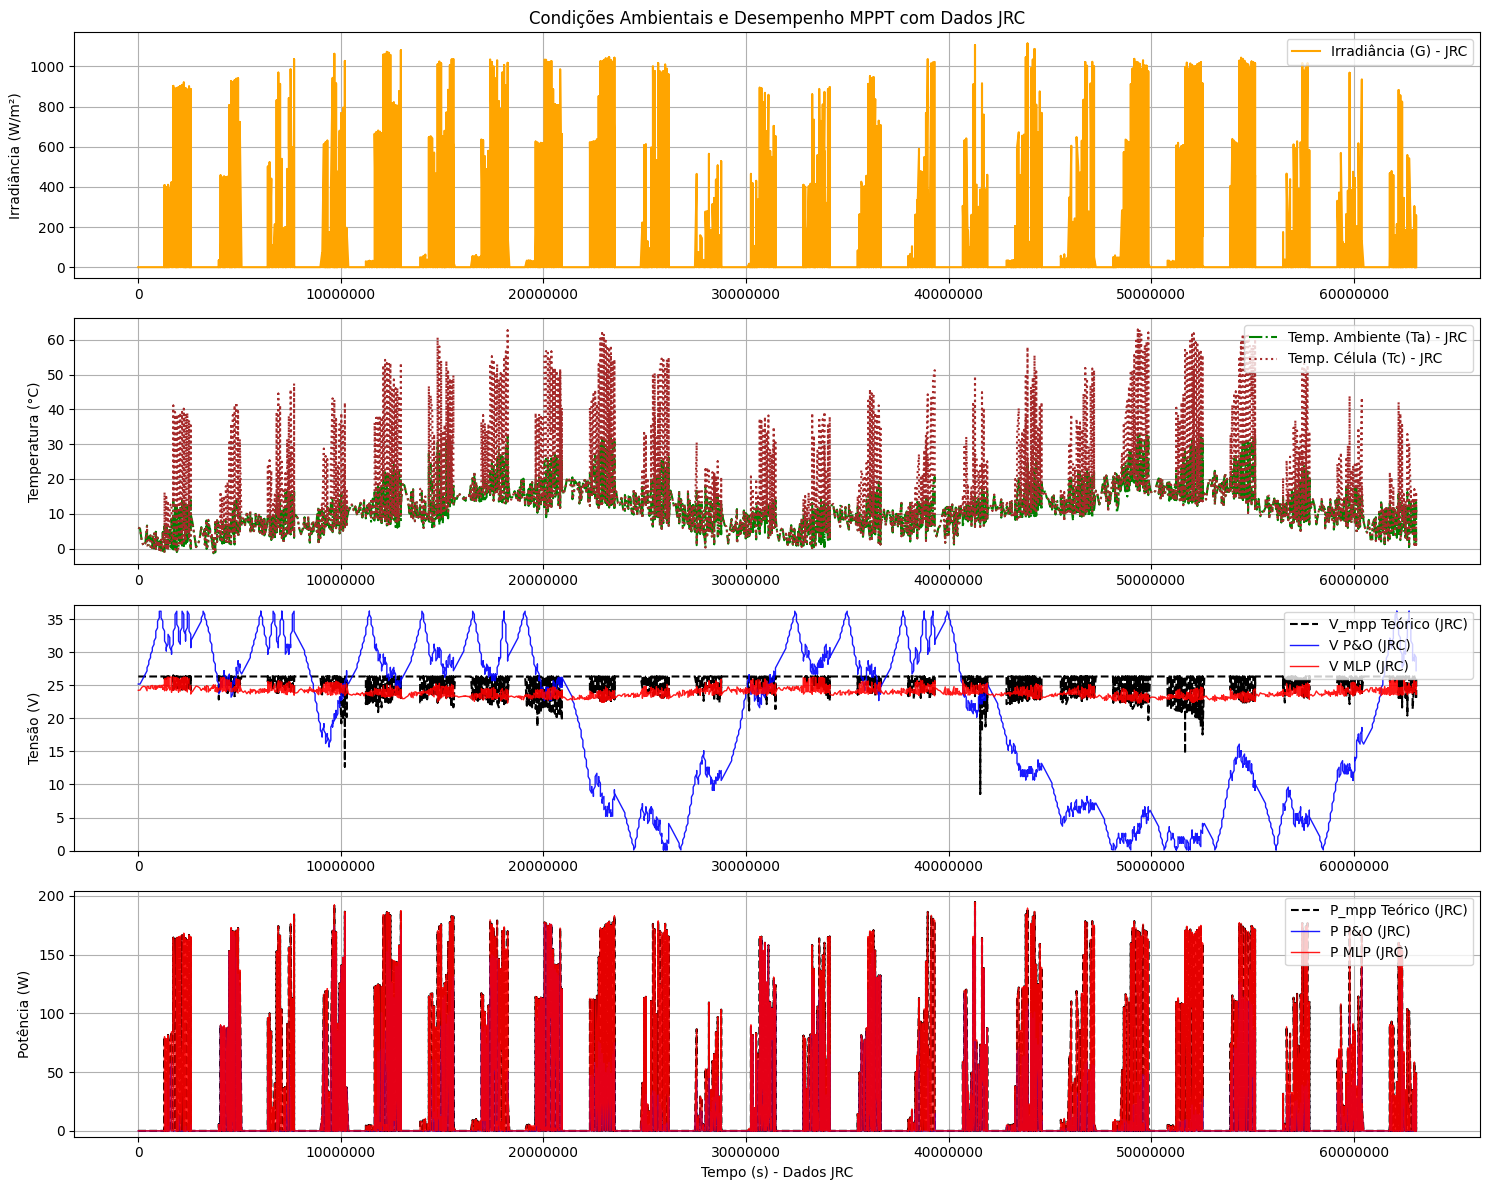

In [ ]:
# ==============================================================================
# Plotagem dos Resultados da Simulação com Dados JRC
# ==============================================================================
print("\n--- Plotando Resultados da Simulação com Dados JRC ---")

plt.figure(figsize=(15, 12))  # Ajuste o tamanho para acomodar 4 subplots

# GRÁFICO 1: IRRADIÂNCIA (JRC)
plt.subplot(4, 1, 1)
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['G_real'],
         label='Irradiância (G) - JRC', color='orange')
plt.ylabel('Irradiância (W/m²)')
plt.grid(True)
plt.legend(loc='upper right')
plt.title('Condições Ambientais e Desempenho MPPT com Dados JRC')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# GRÁFICO 2: TEMPERATURA (JRC)
plt.subplot(4, 1, 2)
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['Ta_real'],
         label='Temp. Ambiente (Ta) - JRC', color='green', linestyle='-.')
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['Tc_real'],
         label='Temp. Célula (Tc) - JRC', color='brown', linestyle=':')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.legend(loc='upper right')
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# GRÁFICO 3: TENSÃO (JRC)
plt.subplot(4, 1, 3)
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['V_mpp_teorico'],
         label='V_mpp Teórico (JRC)', color='black', linestyle='--', linewidth=1.5)
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['V_po_sim'],
         label='V P&O (JRC)', color='blue', alpha=0.9, linewidth=1)
if mlp_model is not None:
    plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['V_mlp_pred'],
             label='V MLP (JRC)', color='red', alpha=0.9, linewidth=1)
plt.ylabel('Tensão (V)')
plt.grid(True)
plt.legend(loc='upper right')
v_min_plot_jrc = df_resultados_reais_jrc[['V_mpp_teorico', 'V_po_sim', 'V_mlp_pred']].min().min() - 1
v_max_plot_jrc = df_resultados_reais_jrc[['V_mpp_teorico', 'V_po_sim', 'V_mlp_pred']].max().max() + 1
plt.ylim(max(0, v_min_plot_jrc), v_max_plot_jrc)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

# GRÁFICO 4: POTÊNCIA (JRC)
plt.subplot(4, 1, 4)
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['P_mpp_teorico'],
         label='P_mpp Teórico (JRC)', color='black', linestyle='--', linewidth=1.5)
plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['P_po_estimada'],
         label='P P&O (JRC)', color='blue', alpha=0.9, linewidth=1)
if mlp_model is not None:
    plt.plot(df_resultados_reais_jrc['Tempo'], df_resultados_reais_jrc['P_mlp_estimada'],
             label='P MLP (JRC)', color='red', alpha=0.9, linewidth=1)
plt.ylabel('Potência (W)')
plt.xlabel('Tempo (s) - Dados JRC')
plt.grid(True)
plt.legend(loc='upper right')
p_min_plot_jrc = -5
p_max_plot_jrc = df_resultados_reais_jrc['P_mpp_teorico'].max() * 1.05 if not df_resultados_reais_jrc['P_mpp_teorico'].empty else 100
plt.ylim(p_min_plot_jrc, p_max_plot_jrc)
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0f'))

plt.tight_layout()
plt.show()

In [ ]:
# ==============================================================================
# Cálculo de Métricas de Avaliação com Dados JRC
# ==============================================================================
print("\n--- Métricas de Avaliação com Dados JRC ---")

P_real_jrc = df_resultados_reais_jrc['P_mpp_teorico'].values
V_real_jrc = df_resultados_reais_jrc['V_mpp_teorico'].values
P_po_jrc = df_resultados_reais_jrc['P_po_estimada'].values
V_po_jrc = df_resultados_reais_jrc['V_po_sim'].values
P_mlp_jrc = df_resultados_reais_jrc['P_mlp_estimada'].values
V_mlp_jrc = df_resultados_reais_jrc['V_mlp_pred'].values

soma_P_real_jrc = np.sum(P_real_jrc)

if soma_P_real_jrc < 1e-6:
    print("Aviso: Potência máxima teórica total (JRC) é próxima de zero. Eficiência não pode ser calculada.")
    eff_po_jrc, eff_mlp_jrc = 0.0, 0.0
else:
    eff_po_jrc = (np.sum(P_po_jrc) / soma_P_real_jrc) * 100
    if mlp_model is not None:
        eff_mlp_jrc = (np.sum(P_mlp_jrc) / soma_P_real_jrc) * 100
    else:
        eff_mlp_jrc = 0.0

mae_p_po_jrc = mean_absolute_error(P_real_jrc, P_po_jrc)
rmse_p_po_jrc = np.sqrt(mean_squared_error(P_real_jrc, P_po_jrc))
mae_v_po_jrc = mean_absolute_error(V_real_jrc, V_po_jrc)
rmse_v_po_jrc = np.sqrt(mean_squared_error(V_real_jrc, V_po_jrc))

print("\n--- Algoritmo P&O (Dados JRC) ---")
print(f"Eficiência de Rastreamento (Energia): {eff_po_jrc:.2f}%")
print(f"MAE - Potência: {mae_p_po_jrc:.4f} W, RMSE - Potência: {rmse_p_po_jrc:.4f} W")
print(f"MAE - Tensão: {mae_v_po_jrc:.4f} V, RMSE - Tensão: {rmse_v_po_jrc:.4f} V")

print("\n--- Modelo MLP (Dados JRC) ---")
if mlp_model is not None:
    mae_p_mlp_jrc = mean_absolute_error(P_real_jrc, P_mlp_jrc)
    rmse_p_mlp_jrc = np.sqrt(mean_squared_error(P_real_jrc, P_mlp_jrc))
    mae_v_mlp_jrc = mean_absolute_error(V_real_jrc, V_mlp_jrc)
    rmse_v_mlp_jrc = np.sqrt(mean_squared_error(V_real_jrc, V_mlp_jrc))

    print(f"Eficiência de Rastreamento (Energia): {eff_mlp_jrc:.2f}%")
    print(f"MAE - Potência: {mae_p_mlp_jrc:.4f} W, RMSE - Potência: {rmse_p_mlp_jrc:.4f} W")
    print(f"MAE - Tensão: {mae_v_mlp_jrc:.4f} V, RMSE - Tensão: {rmse_v_mlp_jrc:.4f} V")
else:
    print("Métricas não calculadas pois o modelo MLP não foi treinado.")


--- Métricas de Avaliação com Dados JRC ---

--- Algoritmo P&O (Dados JRC) ---
Eficiência de Rastreamento (Energia): 48.53%
MAE - Potência: 14.7212 W, RMSE - Potência: 37.5939 W
MAE - Tensão: 10.0455 V, RMSE - Tensão: 12.6501 V

--- Modelo MLP (Dados JRC) ---
Eficiência de Rastreamento (Energia): 99.94%
MAE - Potência: 0.0185 W, RMSE - Potência: 0.0722 W
MAE - Tensão: 1.7867 V, RMSE - Tensão: 2.1764 V


In [ ]:
# ==============================================================================
# 10. Simulação Dinâmica e Comparação (AGORA COM G e Ta VARIÁVEIS)
# ==============================================================================

# Cenário de Simulação
tempo_total = 60  # segundos (Aumentado para ver mais variações, como no plot original)
dt = 0.1         # passo de tempo da simulação (s) - Ajustado para corresponder ao gráfico
num_passos = int(tempo_total / dt)
tempo = np.linspace(0, tempo_total, num_passos)

# Condições Ambientais Variáveis
G_sim = np.zeros(num_passos)
T_a_sim = np.zeros(num_passos) # Agora T_a também varia

# --- Define os degraus de irradiância (como no gráfico original) ---
G_sim[tempo < 5] = 500
G_sim[(tempo >= 5) & (tempo < 15)] = 900
G_sim[(tempo >= 15) & (tempo < 25)] = 650
G_sim[(tempo >= 25) & (tempo < 35)] = 1000
G_sim[(tempo >= 35) & (tempo < 45)] = 750
G_sim[(tempo >= 45) & (tempo < 55)] = 850
G_sim[tempo >= 55] = 400

# --- Define um perfil para a Temperatura Ambiente (Exemplo: Senoidal + Base) ---
# Simula uma variação de temperatura ao longo do "dia" da simulação
T_a_base = 25.0  # Temperatura média (°C)
T_a_amplitude = 10.0 # Amplitude da variação (°C) -> Varia entre 15°C e 35°C
# Frequencia para completar meio ciclo ao longo do tempo total (simulando manhã -> tarde)
omega_T = np.pi / tempo_total # Angular frequency
T_a_sim = T_a_base + T_a_amplitude * np.sin(omega_T * tempo)
# Ou, se preferir degraus de temperatura (menos realista, mas mais fácil de correlacionar):
# T_a_sim[tempo < 15] = 20
# T_a_sim[(tempo >= 15) & (tempo < 35)] = 30
# T_a_sim[(tempo >= 35) & (tempo < 50)] = 35
# T_a_sim[tempo >= 50] = 25

# Calcula a Temperatura da Célula baseada em G e Ta variáveis
T_c_sim = T_a_sim + 0.03 * G_sim # Temperatura da célula agora depende de T_a(t) e G(t)

# Inicialização dos algoritmos
pno = PnO_MPPT(V_inicial=Vocn*0.7, passo_V_inicial=0.5) # Começar mais perto do Vmpp esperado

# Armazenamento dos resultados
resultados_dinamicos = {
    'Tempo': tempo, 'G': G_sim, 'T_a': T_a_sim, 'T_c': T_c_sim, # Adicionado T_a
    'V_mpp_real': np.zeros(num_passos), 'P_mpp_real': np.zeros(num_passos),
    'V_po': np.zeros(num_passos), 'P_po': np.zeros(num_passos),
    'V_mlp': np.zeros(num_passos), 'P_mlp': np.zeros(num_passos),
}

print("\nIniciando simulação dinâmica com P&O e MLP (G e Ta variáveis)...")
start_time_dyn = time.time()

# Calcular MPP Real inicial
V_mpp_ideal_0, P_mpp_ideal_0 = encontrar_mpp_real(G_sim[0], T_c_sim[0])
resultados_dinamicos['V_mpp_real'][0] = V_mpp_ideal_0
resultados_dinamicos['P_mpp_real'][0] = P_mpp_ideal_0

# Valores iniciais P&O
V_po_0, P_po_0 = pno.step(G_sim[0], T_c_sim[0]) # Primeira chamada
resultados_dinamicos['V_po'][0] = pno.V_atual # Pega a tensão *depois* da primeira perturbação
# Calcula a potência no ponto inicial antes da perturbação para P_po[0]
resultados_dinamicos['P_po'][0] = calcular_potencia_pv(pno.V_anterior, G_sim[0], T_c_sim[0])

# Previsão MLP inicial
V_mlp_pred_0 = prever_vmpp_mlp(G_sim[0], T_a_sim[0], mlp_model, scaler_G, scaler_Ta, scaler_Vmpp)
P_mlp_calc_0 = calcular_potencia_pv(V_mlp_pred_0, G_sim[0], T_c_sim[0])
resultados_dinamicos['V_mlp'][0] = V_mlp_pred_0
resultados_dinamicos['P_mlp'][0] = P_mlp_calc_0


for i in range(1, num_passos): # Começa do segundo passo
    G_atual = G_sim[i]
    T_a_atual = T_a_sim[i] # Agora pega a T_a variável
    T_c_atual = T_c_sim[i] # T_c correspondente

    # 1. Calcular MPP Ideal
    V_mpp_ideal, P_mpp_ideal = encontrar_mpp_real(G_atual, T_c_atual)
    resultados_dinamicos['V_mpp_real'][i] = V_mpp_ideal
    resultados_dinamicos['P_mpp_real'][i] = P_mpp_ideal

    # 2. Simular um passo do P&O
    # step() usa G_atual, T_c_atual para calcular a potência no ponto V_atual (que foi definido no passo i-1)
    # e retorna V e P *desse ponto* (V_anterior, P_atual_calculada)
    V_po_step, P_po_step = pno.step(G_atual, T_c_atual)
    resultados_dinamicos['V_po'][i] = V_po_step
    resultados_dinamicos['P_po'][i] = P_po_step # Potência no ponto V_po_step

    # 3. Calcular saída do MLP
    # MLP usa G_atual e T_a_atual
    V_mlp_pred = prever_vmpp_mlp(G_atual, T_a_atual, mlp_model, scaler_G, scaler_Ta, scaler_Vmpp)
    # Calcula a potência real obtida com a tensão prevista pelo MLP nas condições atuais
    P_mlp_calc = calcular_potencia_pv(V_mlp_pred, G_atual, T_c_atual)
    resultados_dinamicos['V_mlp'][i] = V_mlp_pred
    resultados_dinamicos['P_mlp'][i] = P_mlp_calc

    # Progresso (opcional)
    # if (i + 1) % (num_passos // 20) == 0:
    #      print(f"Simulado { (i+1)*dt:.2f}s / {tempo_total}s...")

end_time_dyn = time.time()
print(f"Simulação dinâmica concluída em {end_time_dyn - start_time_dyn:.2f} segundos.")

df_resultados_dyn = pd.DataFrame(resultados_dinamicos)


Iniciando simulação dinâmica com P&O e MLP (G e Ta variáveis)...
Simulação dinâmica concluída em 2.34 segundos.


In [ ]:
# ==============================================================================
# 11. Cálculo de Métricas de Avaliação
# ==============================================================================
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np # Certifique-se que numpy está importado como np

# Verificar se o DataFrame de resultados existe e não está vazio
if 'df_resultados_dyn' in locals() and not df_resultados_dyn.empty:

    print("\n==============================================")
    print("      Métricas de Avaliação dos Modelos       ")
    print("==============================================")

    # Extrair os dados relevantes do DataFrame
    P_real = df_resultados_dyn['P_mpp_real'].values
    V_real = df_resultados_dyn['V_mpp_real'].values
    P_po = df_resultados_dyn['P_po'].values
    V_po = df_resultados_dyn['V_po'].values
    P_mlp = df_resultados_dyn['P_mlp'].values
    V_mlp = df_resultados_dyn['V_mlp'].values

    # Calcular a soma da potência real (para eficiência) - Evitar divisão por zero
    soma_P_real = np.sum(P_real)
    if soma_P_real < 1e-6: # Se a potência real total for praticamente zero
        print("Aviso: A potência máxima real total é próxima de zero. A eficiência não pode ser calculada.")
        eff_po = 0.0
        eff_mlp = 0.0
    else:
        # --- Métricas para P&O ---
        soma_P_po = np.sum(P_po)
        eff_po = (soma_P_po / soma_P_real) * 100

        # --- Métricas para MLP ---
        soma_P_mlp = np.sum(P_mlp)
        eff_mlp = (soma_P_mlp / soma_P_real) * 100

    # Cálculo de MAE e RMSE (garantir que não há NaNs ou Infs, embora improvável aqui)
    P_real = np.nan_to_num(P_real)
    V_real = np.nan_to_num(V_real)
    P_po = np.nan_to_num(P_po)
    V_po = np.nan_to_num(V_po)
    P_mlp = np.nan_to_num(P_mlp)
    V_mlp = np.nan_to_num(V_mlp)

    # --- Métricas para P&O ---
    mae_p_po = mean_absolute_error(P_real, P_po)
    rmse_p_po = np.sqrt(mean_squared_error(P_real, P_po))
    mae_v_po = mean_absolute_error(V_real, V_po)
    rmse_v_po = np.sqrt(mean_squared_error(V_real, V_po))

    print("\n--- Algoritmo P&O ---")
    print(f"Eficiência de Rastreamento (Energia): {eff_po:.2f}%")
    print(f"Erro Absoluto Médio (MAE) - Potência: {mae_p_po:.4f} W")
    print(f"Raiz do Erro Quadrático Médio (RMSE) - Potência: {rmse_p_po:.4f} W")
    print(f"Erro Absoluto Médio (MAE) - Tensão: {mae_v_po:.4f} V")
    print(f"Raiz do Erro Quadrático Médio (RMSE) - Tensão: {rmse_v_po:.4f} V")

    # --- Métricas para MLP ---
    # Verificar se o modelo MLP foi treinado antes de calcular métricas
    if mlp_model is not None:
        mae_p_mlp = mean_absolute_error(P_real, P_mlp)
        rmse_p_mlp = np.sqrt(mean_squared_error(P_real, P_mlp))
        mae_v_mlp = mean_absolute_error(V_real, V_mlp)
        rmse_v_mlp = np.sqrt(mean_squared_error(V_real, V_mlp))

        print("\n--- Modelo MLP ---")
        print(f"Eficiência de Rastreamento (Energia): {eff_mlp:.2f}%")
        print(f"Erro Absoluto Médio (MAE) - Potência: {mae_p_mlp:.4f} W")
        print(f"Raiz do Erro Quadrático Médio (RMSE) - Potência: {rmse_p_mlp:.4f} W")
        print(f"Erro Absoluto Médio (MAE) - Tensão: {mae_v_mlp:.4f} V")
        print(f"Raiz do Erro Quadrático Médio (RMSE) - Tensão: {rmse_v_mlp:.4f} V")

        # Re-exibir o erro do conjunto de teste do MLP para referência
        if 'rmse_volts' in locals() and rmse_volts is not None:
             print(f"\n(Contexto MLP: RMSE Tensão no Conjunto de Teste original: {rmse_volts:.4f} V)")
        elif 'mse_norm' in locals() and mse_norm is not None:
             # Tenta calcular se não foi feito antes ou se perdeu a variável rmse_volts
             try:
                 y_pred_test_norm_eval = mlp_model.predict(X_test)
                 y_pred_test_eval = scaler_Vmpp.inverse_transform(y_pred_test_norm_eval.reshape(-1, 1))
                 y_test_orig_eval = scaler_Vmpp.inverse_transform(y_test.reshape(-1, 1))
                 rmse_volts_eval = np.sqrt(mean_squared_error(y_test_orig_eval, y_pred_test_eval))
                 print(f"\n(Contexto MLP: RMSE Tensão no Conjunto de Teste original: {rmse_volts_eval:.4f} V)")
             except Exception as e:
                 print(f"\n(Contexto MLP: Não foi possível recalcular RMSE no Conjunto de Teste - {e})")

    else:
        print("\n--- Modelo MLP ---")
        print("Métricas não calculadas pois o modelo MLP não foi treinado.")


    print("==============================================")

else:
    print("\nErro: DataFrame de resultados da simulação dinâmica ('df_resultados_dyn') não encontrado ou vazio.")
    print("As métricas de avaliação não puderam ser calculadas.")


      Métricas de Avaliação dos Modelos       

--- Algoritmo P&O ---
Eficiência de Rastreamento (Energia): 99.84%
Erro Absoluto Médio (MAE) - Potência: 0.2056 W
Raiz do Erro Quadrático Médio (RMSE) - Potência: 0.3194 W
Erro Absoluto Médio (MAE) - Tensão: 0.3332 V
Raiz do Erro Quadrático Médio (RMSE) - Tensão: 0.3997 V

--- Modelo MLP ---
Eficiência de Rastreamento (Energia): 100.00%
Erro Absoluto Médio (MAE) - Potência: 0.0057 W
Raiz do Erro Quadrático Médio (RMSE) - Potência: 0.0081 W
Erro Absoluto Médio (MAE) - Tensão: 0.0582 V
Raiz do Erro Quadrático Médio (RMSE) - Tensão: 0.0681 V

(Contexto MLP: RMSE Tensão no Conjunto de Teste original: 0.0822 V)


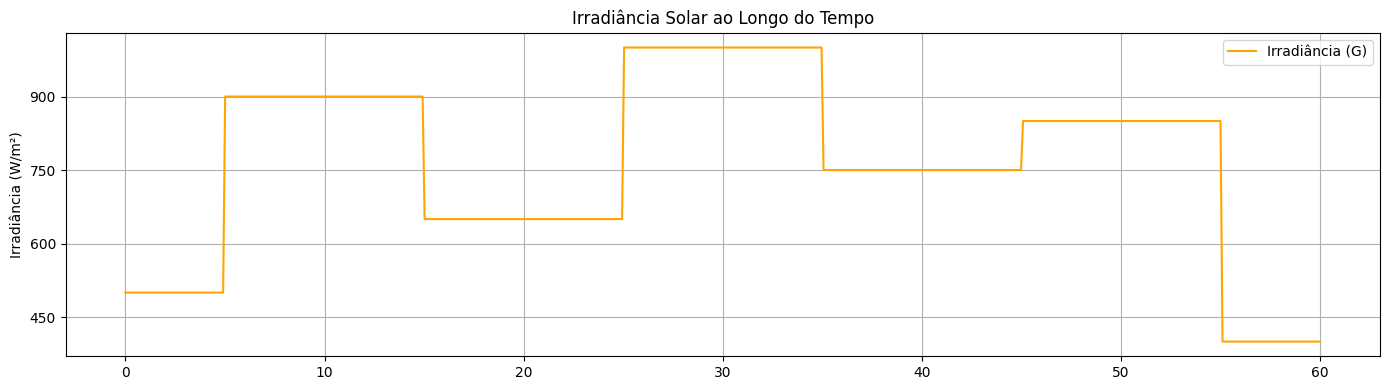

In [ ]:
# ==============================================================================
# 12. Plotagem dos Resultados (ATUALIZADO PARA 4 GRÁFICOS)
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

if 'df_resultados_dyn' in locals() and not df_resultados_dyn.empty:

    # ===================== GRÁFICO 1: IRRADIÂNCIA =====================
    plt.figure(figsize=(14, 4))
    plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['G'], label='Irradiância (G)', color='orange')
    plt.ylabel('Irradiância (W/m²)')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.title('Irradiância Solar ao Longo do Tempo')
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins=6))
    plt.tight_layout()
    plt.show()

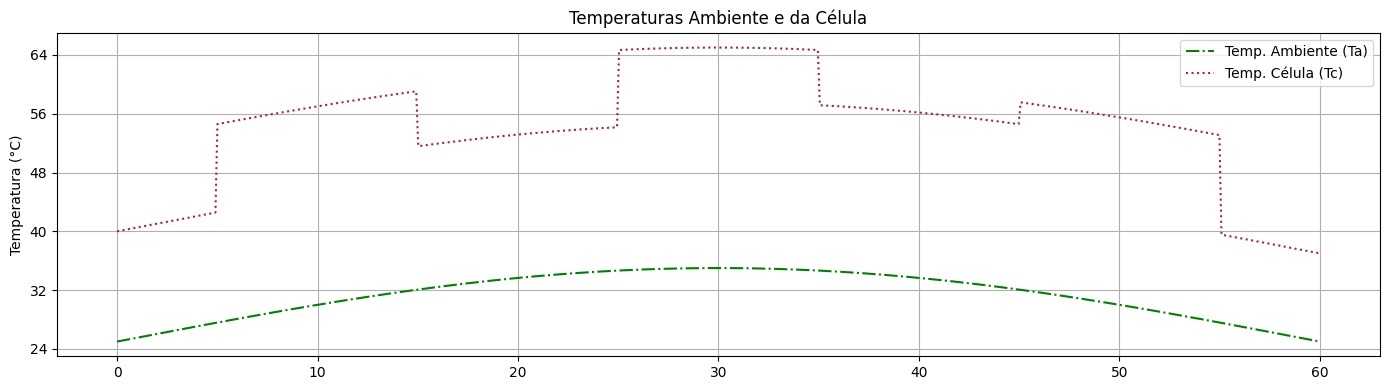

In [ ]:
    # ===================== GRÁFICO 2: TEMPERATURA =====================
    plt.figure(figsize=(14, 4))
    plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['T_a'], label='Temp. Ambiente (Ta)', color='green', linestyle='-.')
    plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['T_c'], label='Temp. Célula (Tc)', color='brown', linestyle=':')
    plt.ylabel('Temperatura (°C)')
    plt.grid(True)
    plt.legend(loc='upper right')
    plt.title('Temperaturas Ambiente e da Célula')
    plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
    plt.tight_layout()
    plt.show()

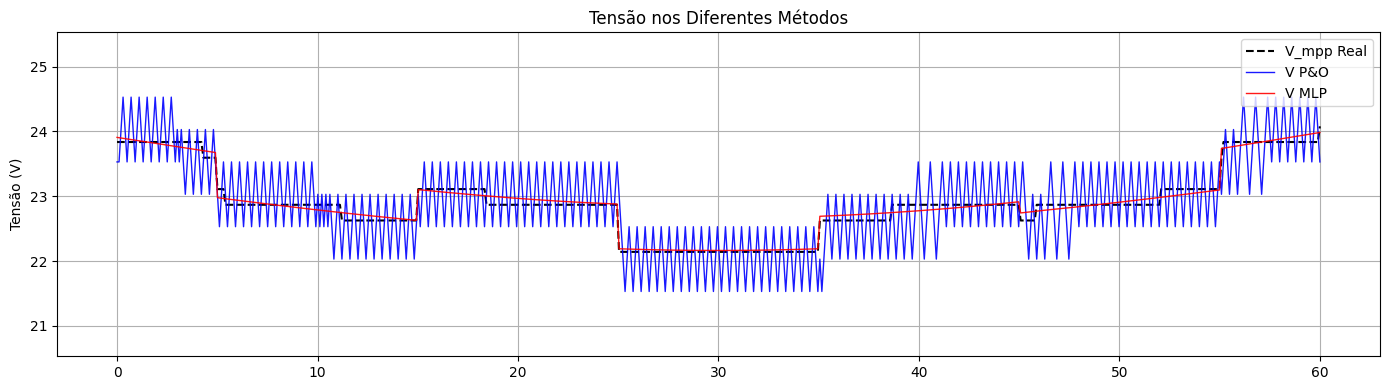

In [ ]:
# ===================== GRÁFICO 3: TENSÃO =====================
plt.figure(figsize=(14, 4))
plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['V_mpp_real'], label='V_mpp Real', color='black', linestyle='--', linewidth=1.5)
plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['V_po'], label='V P&O', color='blue', alpha=0.9, linewidth=1)
if mlp_model is not None:
    plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['V_mlp'], label='V MLP', color='red', alpha=0.9, linewidth=1)
plt.ylabel('Tensão (V)')
plt.grid(True)
plt.legend(loc='upper right')
v_min_plot = df_resultados_dyn[['V_mpp_real', 'V_po', 'V_mlp']].min().min() - 1
v_max_plot = df_resultados_dyn[['V_mpp_real', 'V_po', 'V_mlp']].max().max() + 1
plt.ylim(max(0, v_min_plot), v_max_plot)
plt.title('Tensão nos Diferentes Métodos')
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.tight_layout()
plt.show()

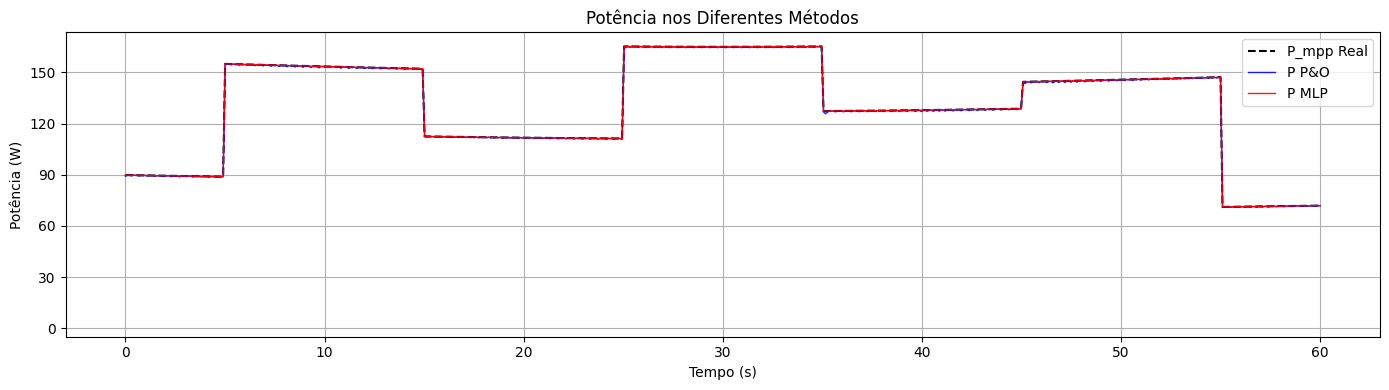

In [ ]:
# ===================== GRÁFICO 4: POTÊNCIA =====================
plt.figure(figsize=(14, 4))
plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['P_mpp_real'], label='P_mpp Real', color='black', linestyle='--', linewidth=1.5)
plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['P_po'], label='P P&O', color='blue', alpha=0.9, linewidth=1)
if mlp_model is not None:
    plt.plot(df_resultados_dyn['Tempo'], df_resultados_dyn['P_mlp'], label='P MLP', color='red', alpha=0.9, linewidth=1)
plt.ylabel('Potência (W)')
plt.xlabel('Tempo (s)')
plt.grid(True)
plt.legend(loc='upper right')
p_min_plot = -5
p_max_plot = df_resultados_dyn['P_mpp_real'].max() * 1.05
plt.ylim(p_min_plot, p_max_plot)
plt.title('Potência nos Diferentes Métodos')
plt.gca().yaxis.set_major_locator(ticker.MaxNLocator(nbins=6))
plt.tight_layout()
plt.show()

In [ ]:
# Calcular Eficiência Média (opcional)
# Evitar divisão por zero se P_mpp_real for zero em algum ponto
mask_p_real_valido = df_resultados_dyn['P_mpp_real'] > 1e-3

if np.any(mask_p_real_valido):
    eficiencia_po = np.mean(df_resultados_dyn['P_po'][mask_p_real_valido] / df_resultados_dyn['P_mpp_real'][mask_p_real_valido]) * 100
    eficiencia_mlp = np.mean(df_resultados_dyn['P_mlp'][mask_p_real_valido] / df_resultados_dyn['P_mpp_real'][mask_p_real_valido]) * 100
    print(f"\nEficiência Média de Rastreamento (onde P_real > 0):")
    print(f"  P&O: {eficiencia_po:.2f}%")
    print(f"  MLP: {eficiencia_mlp:.2f}%")
else:
    print("\nNão foi possível calcular a eficiência (P_mpp_real foi zero ou inválido).")

print("\nAnálise concluída.")


Eficiência Média de Rastreamento (onde P_real > 0):
  P&O: 99.84%
  MLP: 100.00%

Análise concluída.



Gerando gráfico Scatter Plot comparativo de potência...


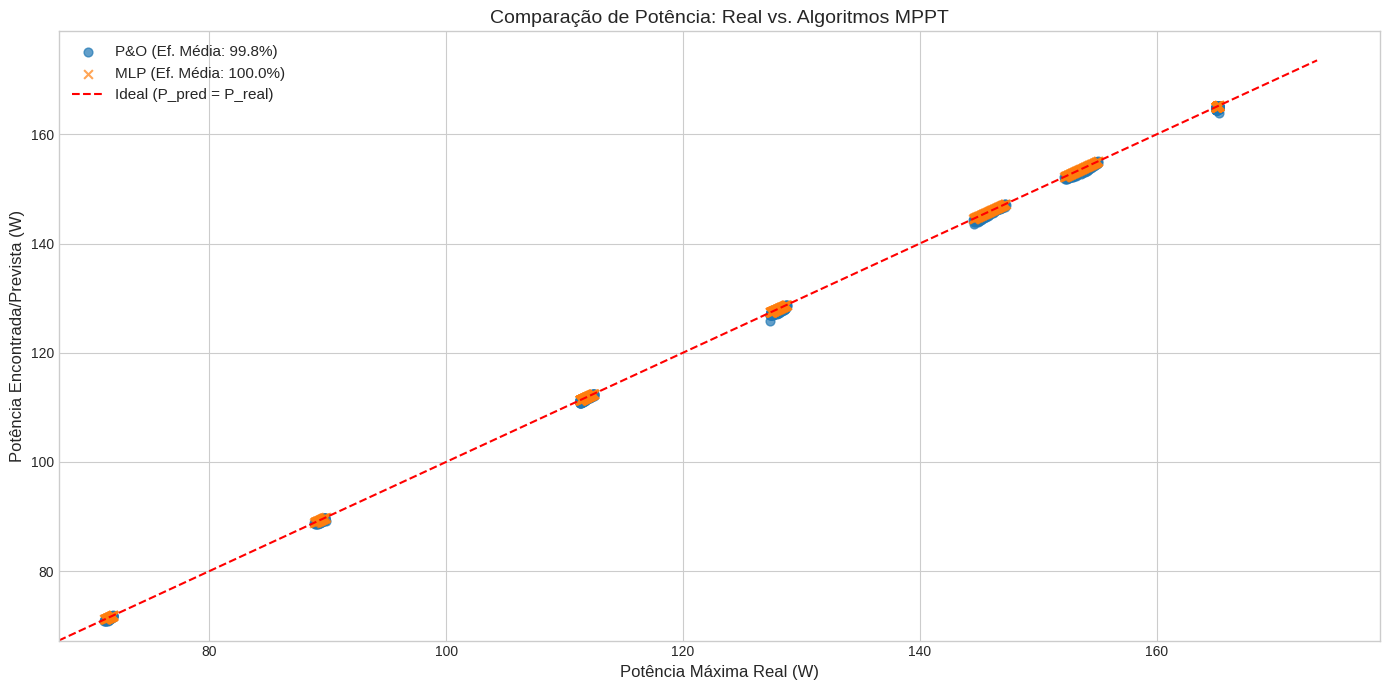

In [ ]:
# ==============================================================================
# 13. Plotagem Adicional: Scatter Plot Comparativo de Potência
# ==============================================================================
import matplotlib.pyplot as plt
import numpy as np

# Verifica se os resultados e as métricas de eficiência existem
if ('df_resultados_dyn' in locals() and not df_resultados_dyn.empty and
    'eff_po' in locals() and # Verifica se a eficiência do P&O foi calculada
    ('mlp_model' not in locals() or mlp_model is None or 'eff_mlp' in locals())): # Verifica se MLP não existe ou sua eficiência foi calculada

    print("\nGerando gráfico Scatter Plot comparativo de potência...")

    # Extrair dados necessários
    P_real = df_resultados_dyn['P_mpp_real'].values
    P_po = df_resultados_dyn['P_po'].values
    if mlp_model is not None:
        P_mlp = df_resultados_dyn['P_mlp'].values

    # Definir estilo (similar ao da imagem)
    try:
        plt.style.use('seaborn-v0_8-whitegrid')
    except OSError:
        print("Estilo 'seaborn-v0_8-whitegrid' não encontrado, usando estilo padrão.")
        plt.style.use('default') # Fallback para estilo padrão

    fig_scatter, ax_scatter = plt.subplots(figsize=(14, 7)) # Ajuste o tamanho conforme necessário

    # Plotar P&O
    # Usar a eficiência calculada na Seção 7 (baseada na energia total)
    label_po = f'P&O (Ef. Média: {eff_po:.1f}%)'
    ax_scatter.scatter(P_real, P_po, label=label_po, marker='o', alpha=0.7, s=40) # s ajusta o tamanho do marcador

    # Plotar MLP (se existir)
    # Usar a eficiência calculada na Seção 7 (baseada na energia total)
    if mlp_model is not None and 'eff_mlp' in locals():
         label_mlp = f'MLP (Ef. Média: {eff_mlp:.1f}%)' # Substituímos Fuzzy por MLP
         ax_scatter.scatter(P_real, P_mlp, label=label_mlp, marker='x', alpha=0.7, s=40)

    # Plotar Linha Ideal (y=x)
    # Determinar limites para a linha ideal
    min_val = np.min([P_real.min(), P_po.min()])
    max_val = np.max([P_real.max(), P_po.max()])
    if mlp_model is not None and 'P_mlp' in locals():
        min_val = np.min([min_val, P_mlp.min()])
        max_val = np.max([max_val, P_mlp.max()])

    # Adicionar uma pequena margem
    plot_min = min_val * 0.95
    plot_max = max_val * 1.05
    ideal_line = np.linspace(plot_min, plot_max, 100)
    ax_scatter.plot(ideal_line, ideal_line, color='red', linestyle='--', label='Ideal (P_pred = P_real)')

    # Configurar Labels, Título e Legenda
    ax_scatter.set_xlabel('Potência Máxima Real (W)', fontsize=12)
    ax_scatter.set_ylabel('Potência Encontrada/Prevista (W)', fontsize=12)
    ax_scatter.set_title('Comparação de Potência: Real vs. Algoritmos MPPT', fontsize=14)
    ax_scatter.legend(fontsize=11)
    ax_scatter.grid(True) # Grid já é parte do estilo seaborn-whitegrid, mas não custa garantir

    # Ajustar limites dos eixos se necessário (opcional, geralmente automático funciona bem)
    ax_scatter.set_xlim(left=plot_min)
    ax_scatter.set_ylim(bottom=plot_min)

    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show()

else:
    print("\nNão foi possível gerar o gráfico Scatter Plot.")
    if 'df_resultados_dyn' not in locals() or df_resultados_dyn.empty:
        print(" - DataFrame 'df_resultados_dyn' não encontrado ou vazio.")
    if 'eff_po' not in locals():
         print(" - Métrica 'eff_po' não encontrada (verifique a Seção 7).")
    if 'mlp_model' in locals() and mlp_model is not None and 'eff_mlp' not in locals():
         print(" - Métrica 'eff_mlp' não encontrada (verifique a Seção 7).")

In [ ]:
# No final do script, após todas as métricas serem calculadas

print("\n--- Comparação do Desempenho de Generalização do MLP ---")

# Métricas do Test Set Original (calculadas na Seção 3)
if 'rmse_volts' in locals(): # Usando rmse_volts como indicador de que a avaliação foi feita
     print("\nDesempenho no Test Set (Dados Estáticos):")
     # Re-imprima ou recupere as métricas relevantes do test set original, se necessário
     # Exemplo: print(f"  RMSE Tensão: {rmse_volts:.4f} V")
     # Se você calculou eficiência ou MAE no test set original, imprima-os também.
     # É importante ter uma métrica comparável (ex: RMSE em Volts)
     print(f"  (Contexto MLP: RMSE Tensão no Conjunto de Teste original: {rmse_volts:.4f} V)") # Re-imprimindo o valor existente
else:
     print("\nDesempenho no Test Set (Dados Estáticos): Métricas não disponíveis.")

# Métricas dos Dados JRC (calculadas na Seção 11, após simulação JRC)
if 'eff_mlp_jrc' in locals(): # Usando eff_mlp_jrc como indicador
    print("\nDesempenho nos Dados JRC:")
    print(f"  Eficiência de Rastreamento (Energia): {eff_mlp_jrc:.2f}%")
    print(f"  MAE Potência: {mae_p_mlp_jrc:.4f} W, RMSE Potência: {rmse_p_mlp_jrc:.4f} W")
    print(f"  MAE Tensão: {mae_v_mlp_jrc:.4f} V, RMSE Tensão: {rmse_v_mlp_jrc:.4f} V")
else:
    print("\nDesempenho nos Dados JRC: Métricas não disponíveis (simulação não executada ou MLP não treinado).")

# Métricas dos Dados Sintéticos (calculadas na Seção 11/14, após simulação dinâmica)
if 'eff_mlp' in locals() and 'mae_v_mlp' in locals(): # Usando eff_mlp/mae_v_mlp como indicador
    print("\nDesempenho nos Dados Sintéticos:")
    print(f"  Eficiência de Rastreamento (Energia): {eff_mlp:.2f}%") # Dinâmica
    print(f"  MAE Potência: {mae_p_mlp:.4f} W, RMSE Potência: {rmse_p_mlp:.4f} W") # Dinâmica
    print(f"  MAE Tensão: {mae_v_mlp:.4f} V, RMSE Tensão: {rmse_v_mlp:.4f} V") # Dinâmica
else:
    print("\nDesempenho nos Dados Sintéticos: Métricas não disponíveis (simulação não executada ou MLP não treinado).")


--- Comparação do Desempenho de Generalização do MLP ---

Desempenho no Test Set (Dados Estáticos):
  (Contexto MLP: RMSE Tensão no Conjunto de Teste original: 0.0822 V)

Desempenho nos Dados JRC:
  Eficiência de Rastreamento (Energia): 99.94%
  MAE Potência: 0.0185 W, RMSE Potência: 0.0722 W
  MAE Tensão: 1.7867 V, RMSE Tensão: 2.1764 V

Desempenho nos Dados Sintéticos:
  Eficiência de Rastreamento (Energia): 100.00%
  MAE Potência: 0.0057 W, RMSE Potência: 0.0081 W
  MAE Tensão: 0.0582 V, RMSE Tensão: 0.0681 V
